# Section 5.4 — Bayesian difference between means

This notebook contains the code examples from [Section 5.4 Bayesian difference between means]() from the **No Bullshit Guide to Statistics**.

See also:
- [Half_a_dozen_dmeans_in_Bambi.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/Half_a_dozen_dmeans_in_Bambi.ipynb)
- [compare_iqs2_many_ways.ipynb](./explorations/compare_iqs2_many_ways.ipynb)
- [t-test.ipynb](./explorations/bambi/t-test.ipynb)
- Examples: https://github.com/treszkai/best/tree/master/examples
- Links: https://www.one-tab.com/page/HoSHco_iSG-MHXG7kXOj7g


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bambi as bmb
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
from ministats.utils import savefigure
DESTDIR = "figures/bayes/dmeans"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Introduciton

We'll now  revisit the problem of comparison between two groups from a Bayesian perspective.

## Model

The data models for the two groups are based on Student’s $t$-distribution:

$$
    X \sim \mathcal{T}(\nu, M_X, \Sigma_X)
    \qquad
    \text{and}
    \qquad
    Y \sim \mathcal{T}(\nu, M_Y, \Sigma_Y).
$$

We'll use a normal prior for the means,
half-$t$ priors for standard deviations,
and a gamma distribution for the degrees of freedom parameter:

$$
    M_X, M_Y \sim \mathcal{N}(\mu_{M}, \sigma_{M}),
    \quad
    \Sigma_X, \Sigma_Y \sim \mathcal{T}^+\!(\nu_{\Sigma}, \sigma_{\Sigma}),
    \quad
    \nu \sim \textrm{Gamma}(\alpha,\beta).
$$


### Bambi formula objects

In [4]:
import bambi as bmb
formula = bmb.Formula("y ~ 0 + group",
                      "sigma ~ 0 + group")
formula

Formula('y ~ 0 + group', 'sigma ~ 0 + group')

In [5]:
formula.main, formula.additionals

('y ~ 0 + group', ('sigma ~ 0 + group',))

In [6]:
formula.get_all_formulas()

['y ~ 0 + group', 'sigma ~ 0 + group']

### Choosing priors for log-sigma

#### Normal distribution 

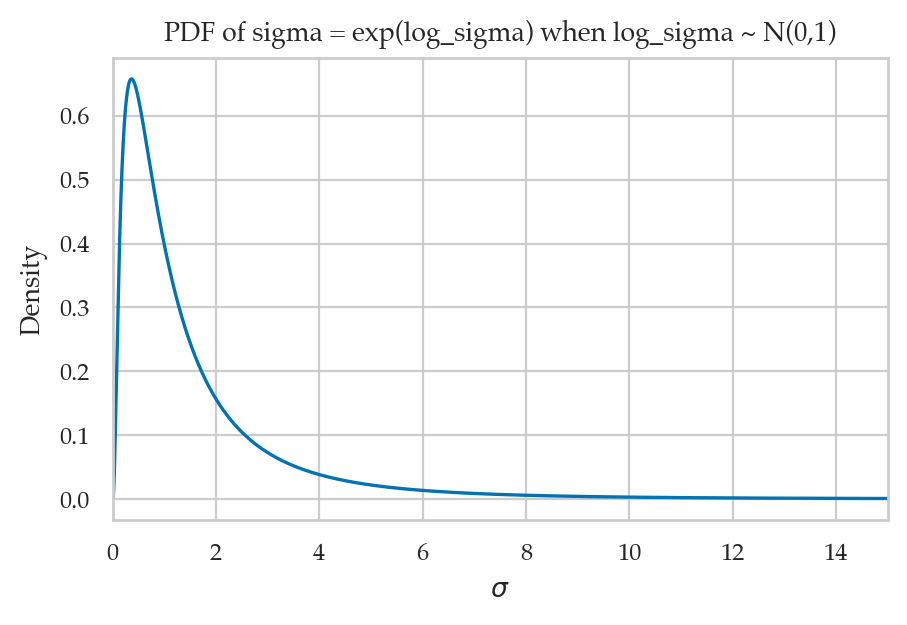

In [7]:
from scipy.stats import norm

logsig = np.linspace(-5, 5, 1000)
density_logsig = norm(0,1).pdf(logsig)
# sns.lineplot(x=logsig, y=density_logsig)

sigma = np.exp(logsig)

# Apply the change of variables to get the density for sigma
# based on the Jacobian adjustment |d(log(sigma))/d(sigma)| = 1/sigma
density_sigma = density_logsig / sigma  

# Plot the transformed density using seaborn
ax = sns.lineplot(x=sigma, y=density_sigma)
ax.set_xlabel('$\\sigma$')
ax.set_ylabel('Density')
ax.set_title('PDF of sigma = exp(log_sigma) when log_sigma ~ N(0,1)')
ax.set_xlim(0, 15);

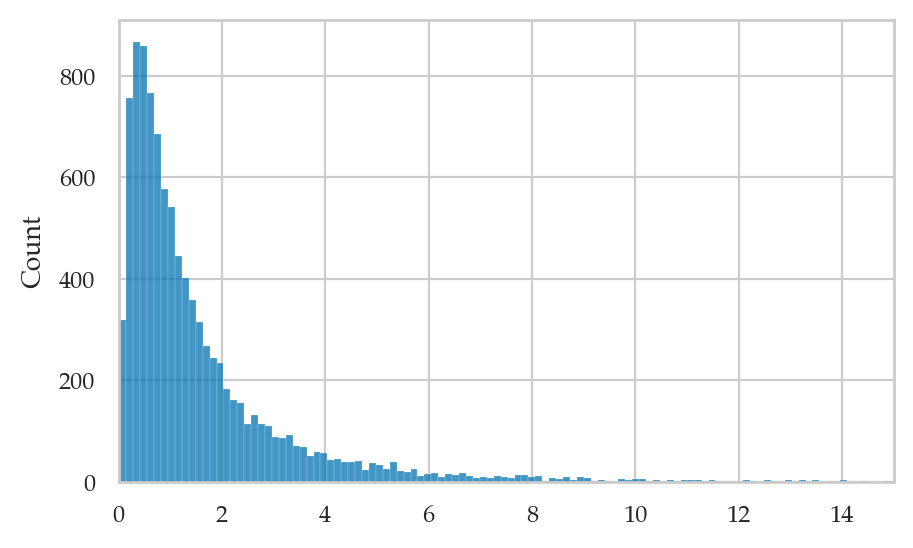

In [8]:
# verify using sampling
N = 10000
logsigs = norm(0,1).rvs(N)
sigs = np.exp(logsigs)
ax = sns.histplot(sigs)
ax.set_xlim(0, 15);

### Gumbel distribution?

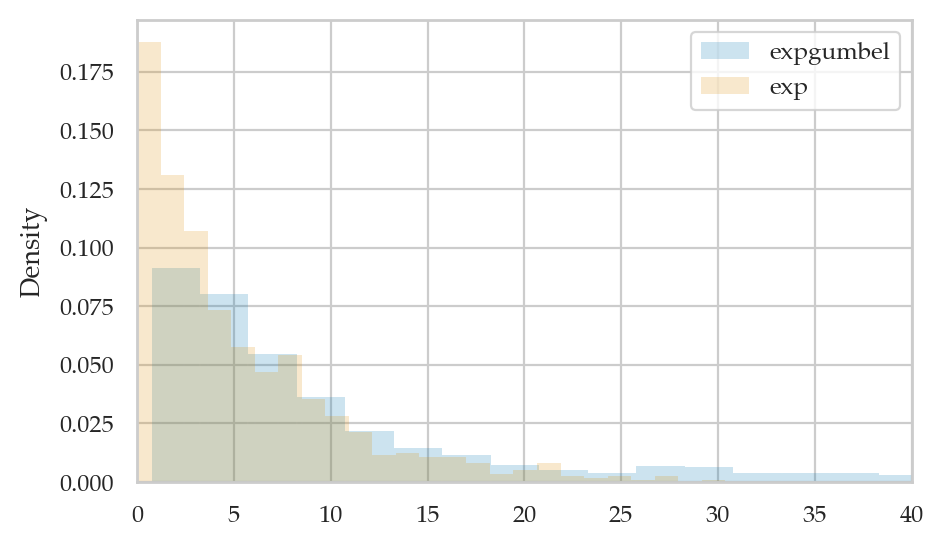

In [9]:
from scipy.stats import gumbel_r, expon

N = 1000
gumbels = gumbel_r(loc=1.609, scale=1).rvs(N)
exp_gumbels = np.exp(gumbels)
exps = expon(loc=0, scale=5).rvs(N)
ax = sns.histplot(exp_gumbels, alpha=0.2, stat="density", label="expgumbel")
sns.histplot(exps, alpha=0.2, stat="density", ax=ax, label="exp")
ax.set_xlim(0, 40);
ax.legend();

## Example 1: comparing electricity prices

Electricity prices from East End and West End

### Electricity prices dataset

In [10]:
eprices = pd.read_csv("../datasets/eprices.csv")
eprices.groupby("loc")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
loc,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


In [11]:
eprices["price"].mean(), eprices["price"].std()

(7.655555555555556, 1.973120020267162)

### Bayesian model
TODO: add formulas

### Bambi model

In [12]:
formula1 = bmb.Formula("price ~ 0 + loc",
                       "sigma ~ 0 + loc")
#######################################################
priors1 = {
    "loc": bmb.Prior("Normal", mu=8, sigma=5),
    "sigma": {
        "loc": bmb.Prior("Normal", mu=0, sigma=1)
    },
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}

mod1 = bmb.Model(formula=formula1,
                 family="t",
                 link="identity",
                 priors=priors1,
                 data=eprices)
mod1

       Formula: price ~ 0 + loc
                sigma ~ 0 + loc
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 18
        Priors: 
    target = mu
        Common-level effects
            loc ~ Normal(mu: 8.0, sigma: 5.0)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_loc ~ Normal(mu: 0.0, sigma: 1.0)

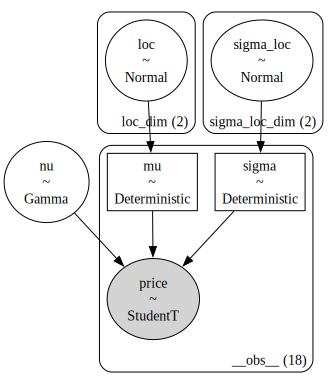

In [13]:
mod1.build()
mod1.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example1_eprices_mod1_graph")
# mod1.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [14]:
idata1 = mod1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, loc, sigma_loc]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [15]:
# ALT. manual calculations
# post1 = idata1["posterior"]
# # Calculate sigmas from log-sigmas
# post1["sigma_treat"] = np.exp(post1["sigma_group"][:,:,1])
# post1["sigma_ctrl"] = np.exp(post1["sigma_group"][:,:,0])
# # Difference in standard deviations
# post1["dstd"] = post1["sigma_treat"] - post1["sigma_ctrl"]

In [16]:
# TODO: replace this with manual steps
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata1, group_name="loc");
#       /replace this with manual steps

az.summary(idata1, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_West", "sigma_East", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,2.934,0.644,1.628,4.155
sigma_West,1.562,0.429,0.855,2.453
sigma_East,0.924,0.275,0.501,1.469
dstd,0.638,0.501,-0.327,1.675
nu,21.347,14.084,1.407,48.918
cohend,2.365,0.710,1.010,3.770


In [17]:
# # ALT. using helper function
# from ministats.bayes import bayes_dmeans
# epricesW = eprices[eprices["loc"]=="West"]["price"]
# epricesE = eprices[eprices["loc"]=="East"]["price"]
# mod1, idata1 = bayes_dmeans(epricesW, epricesE, group_name="loc", var_name="price", groups=["West", "East"])
# mod1

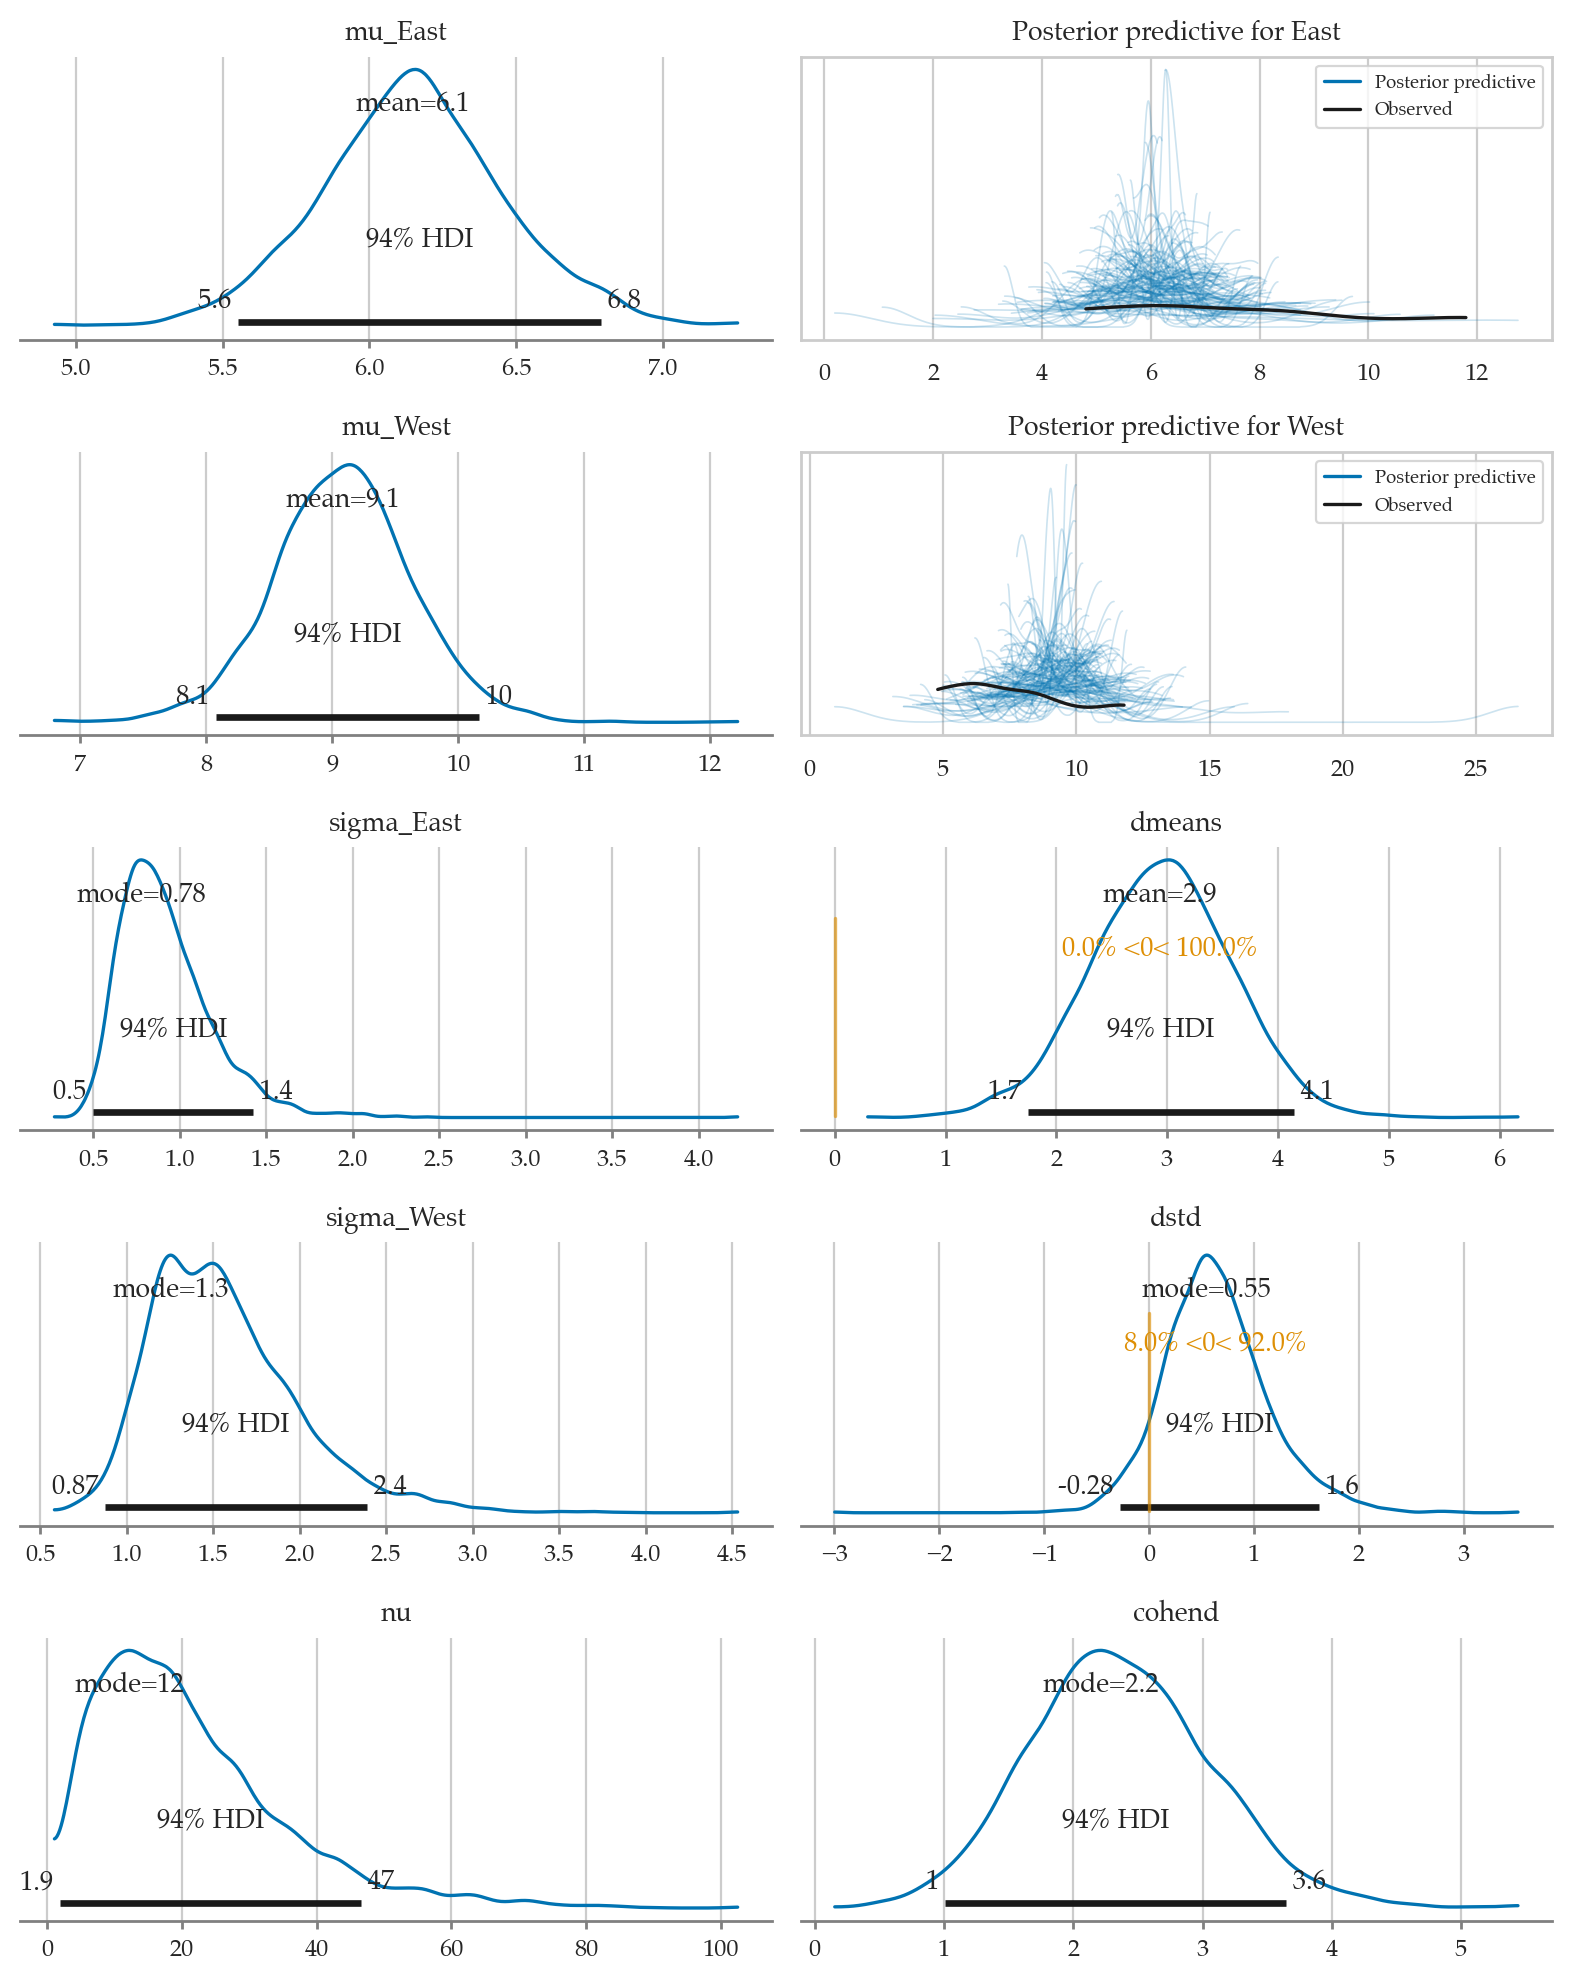

In [18]:
# # ALT. using helper function
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod1, idata1, group_name="loc");

In [19]:
# # FIGURES ONLY
# from ministats.bayes import plot_dmeans_stats
# plot_dmeans_stats(mod1, idata1, group_name="loc",
#                   ppc_xlims=[2,15], figsize=(6,6.5));
# filename = os.path.join(DESTDIR, "example1_dmeans_plots.pdf")
# savefigure(plt.gcf(), filename)

### Compare to frequentist results

In [20]:
from scipy.stats import ttest_ind
pricesW = eprices[eprices["loc"]=="West"]["price"]
pricesE = eprices[eprices["loc"]=="East"]["price"]

res1 = ttest_ind(pricesW, pricesE, equal_var=False)
res1.statistic, res1.pvalue, res1.df

(5.022875513276464, 0.00025703383372176116, 12.592817027231032)

In [21]:
from ministats import cohend2
cohend2(pricesW, pricesE)

2.3678062243290996

### Conclusions

## Example 2: lecture and debate curriculums

### Students dataset

In [22]:
students = pd.read_csv("../datasets/students.csv")
students.groupby("curriculum")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
curriculum,,,,,,,,
debate,8.0,76.462500,10.519633,62.9,69.55,75.55,80.925,96.2
lecture,7.0,68.142857,7.758406,57.0,63.30,70.30,73.850,75.4


### Bayesian model
TODO: add formulas

### Bambi model

In [23]:
formula2 = bmb.Formula("score ~ 0 + curriculum",
                       "sigma ~ 0 + curriculum")

#######################################################
priors1 = {
    "curriculum": bmb.Prior("Normal", mu=70, sigma=30),
    "sigma": {
        "curriculum":bmb.Prior("Normal", mu=0, sigma=1)
    },
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}

mod2 = bmb.Model(formula=formula2,
                 family="t",
                 priors=priors1,
                 data=students)
mod2

       Formula: score ~ 0 + curriculum
                sigma ~ 0 + curriculum
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 15
        Priors: 
    target = mu
        Common-level effects
            curriculum ~ Normal(mu: 70.0, sigma: 30.0)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_curriculum ~ Normal(mu: 0.0, sigma: 1.0)

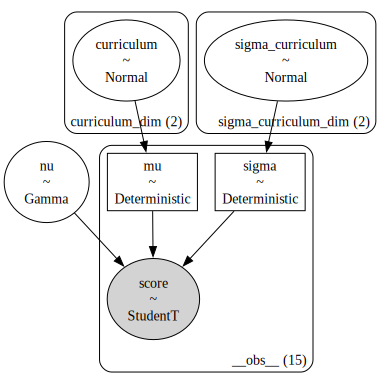

In [24]:
mod2.build()
mod2.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example2_students_mod2_graph")
# mod2.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [25]:
idata2 = mod2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, curriculum, sigma_curriculum]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [26]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata2, group_name="curriculum");
az.summary(idata2, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_debate", "sigma_lecture", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-6.956,4.781,-16.734,2.034
sigma_debate,8.810,2.702,4.086,14.747
sigma_lecture,6.679,2.218,2.177,10.940
dstd,-2.131,3.230,-9.203,3.882
nu,17.479,14.038,0.525,45.322
cohend,-0.903,0.607,-2.108,0.242


In [27]:
# from ministats.bayes import bayes_dmeans

# studentsD = students[students["curriculum"]=="debate"]
# studentsL = students[students["curriculum"]=="lecture"]
# scoresD = studentsD["score"]
# scoresL = studentsL["score"]

# mod2, idata2 = bayes_dmeans(scoresD, scoresL, group_name="curriculum", var_name="score", groups=["debate", "lecture"])
# mod2

In [28]:
# from ministats.bayes import calc_dmeans_stats
# calc_dmeans_stats(idata2, group_name="curriculum");
# az.summary(idata2, kind="stats", hdi_prob=0.95,
#            var_names=["dmeans", "sigma_debate", "sigma_lecture", "dstd", "nu", "cohend"])

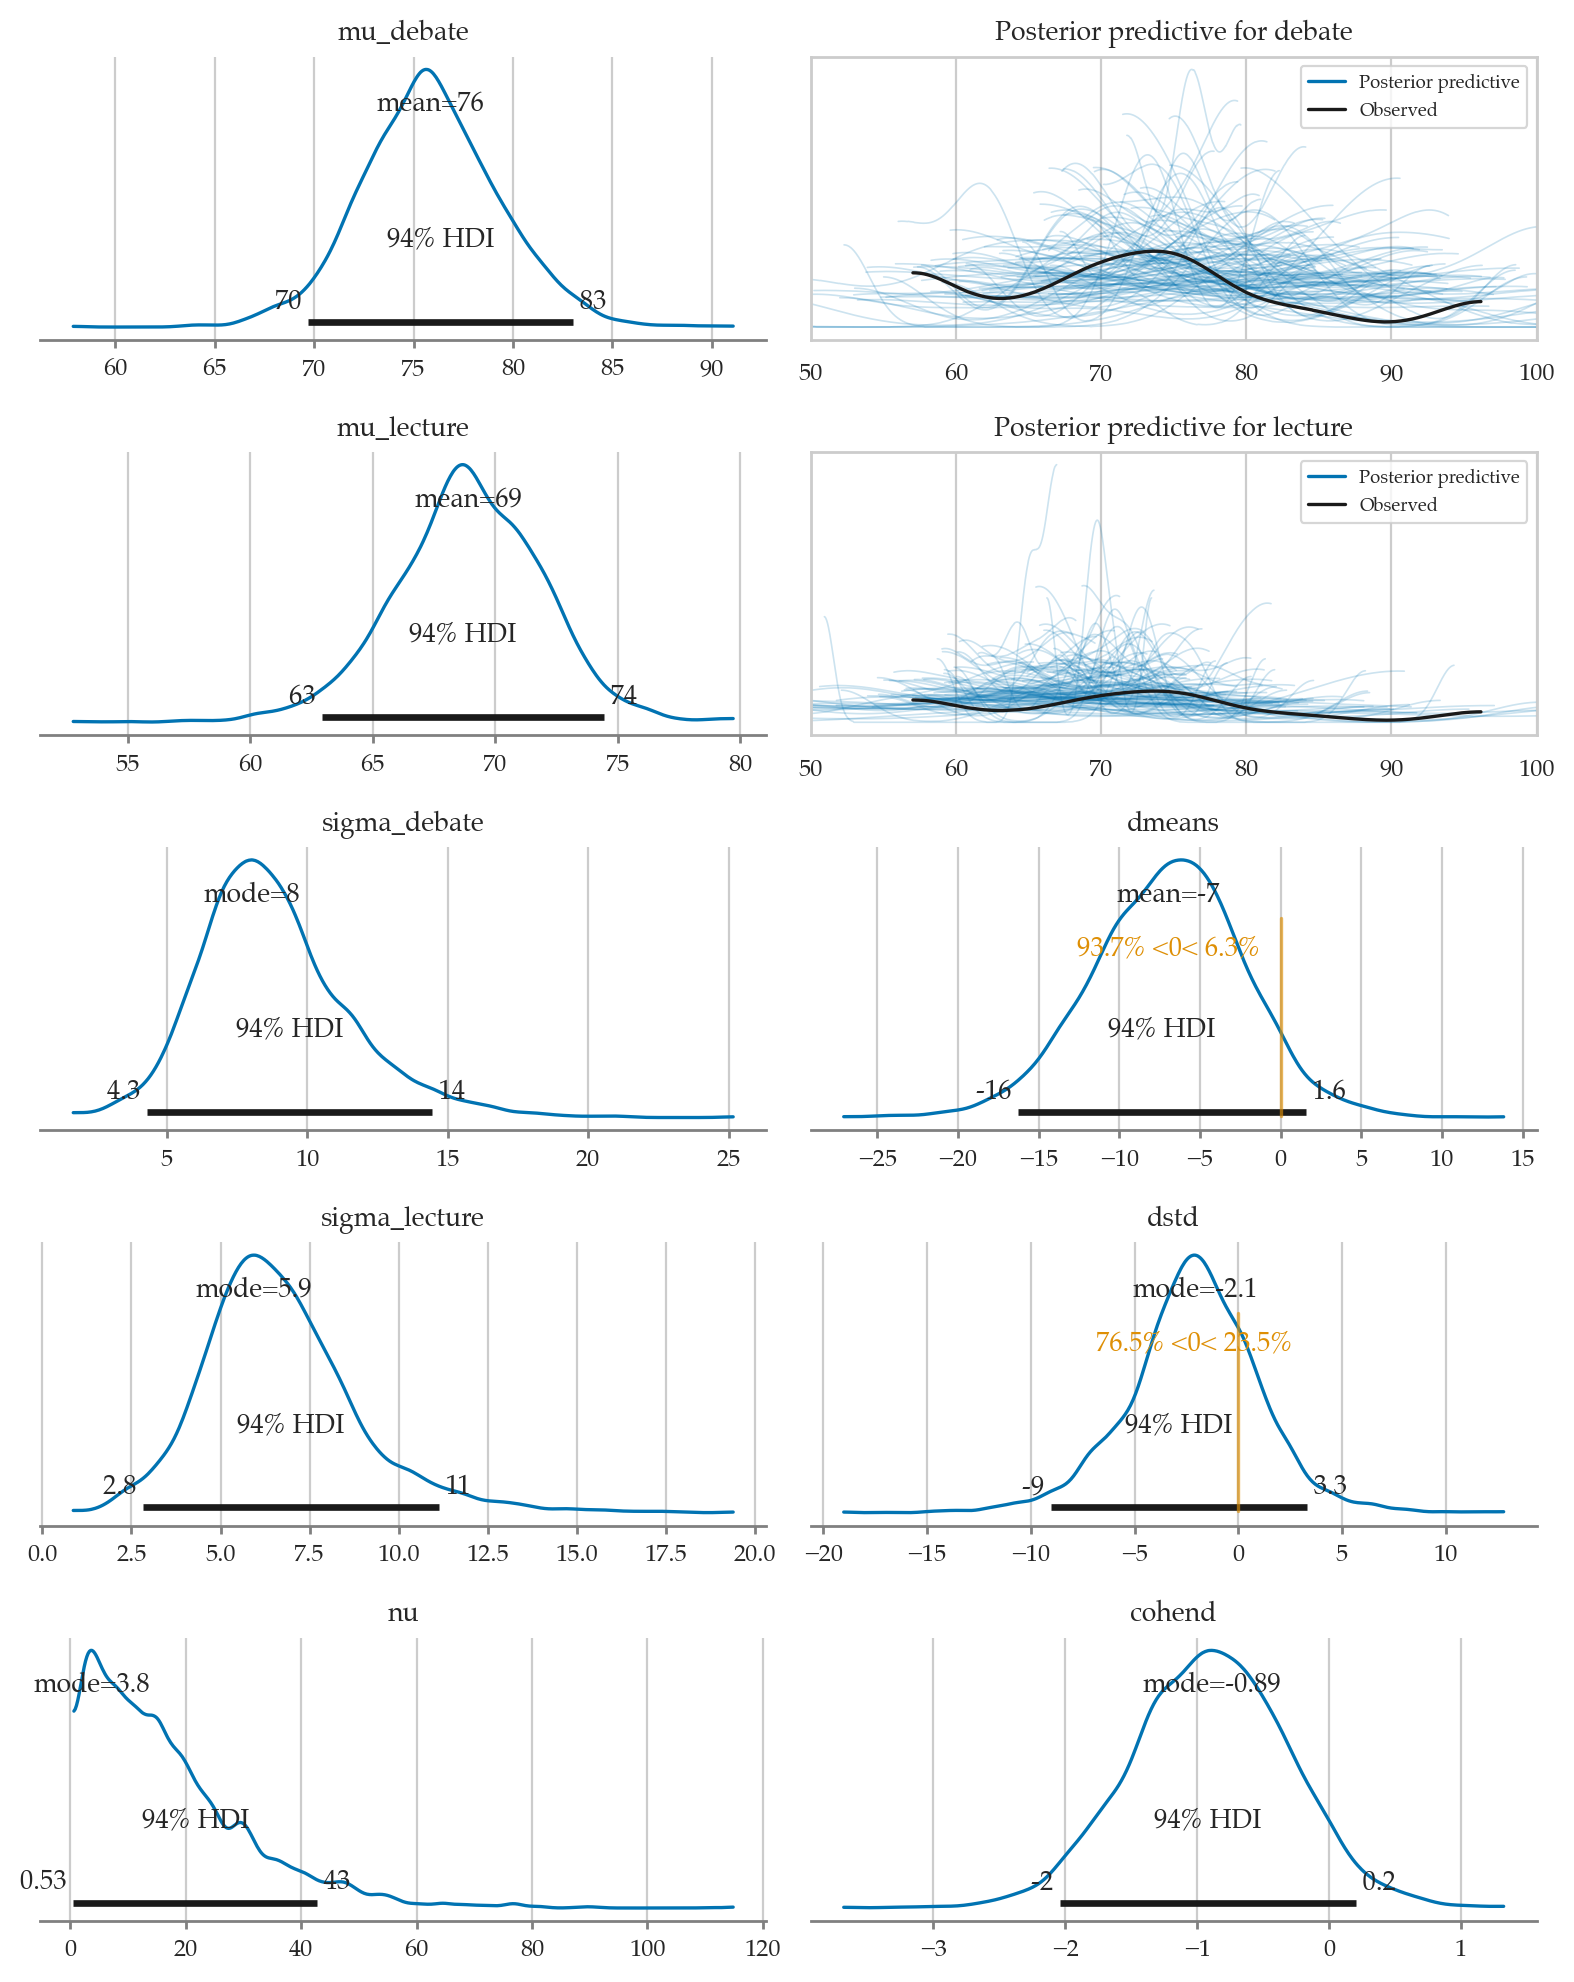

In [29]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod2, idata2, group_name="curriculum", ppc_xlims=[50,100]);

In [30]:
# # FIGURES ONLY
# from ministats.bayes import plot_dmeans_stats
# plot_dmeans_stats(mod2, idata2, group_name="curriculum",
#                   ppc_xlims=[50,100], figsize=(6,6.5));
# filename = os.path.join(DESTDIR, "example2_dmeans_plots.pdf")
# savefigure(plt.gcf(), filename)

### Compare to frequentist results

In [31]:
from scipy.stats import ttest_ind
scoresD = students[students["curriculum"]=="debate"]["score"]
scoresL = students[students["curriculum"]=="lecture"]["score"]

res2 = ttest_ind(scoresD, scoresL, equal_var=False)
res2.statistic, res2.pvalue, res2.df

(1.756598395925055, 0.10307495448387388, 12.687797772640407)

In [32]:
from ministats import cohend2
cohend2(scoresD, scoresL)

0.8900742000749484

### Conclusions

## Example 3: comparing IQ scores

We'll look at IQ scores data taken from a the paper *Bayesian Estimation Supersedes the t-Test* (BEST) by John K. Kruschke.

### IQ scores dataset

In [33]:
iqs2 = pd.read_csv("../datasets/exercises/iqs2.csv")
iqs2.groupby("group")["iq"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctrl,42.0,100.357143,2.516496,88.0,100.0,100.5,101.0,105.0
treat,47.0,101.914894,6.021085,82.0,100.0,102.0,103.0,124.0


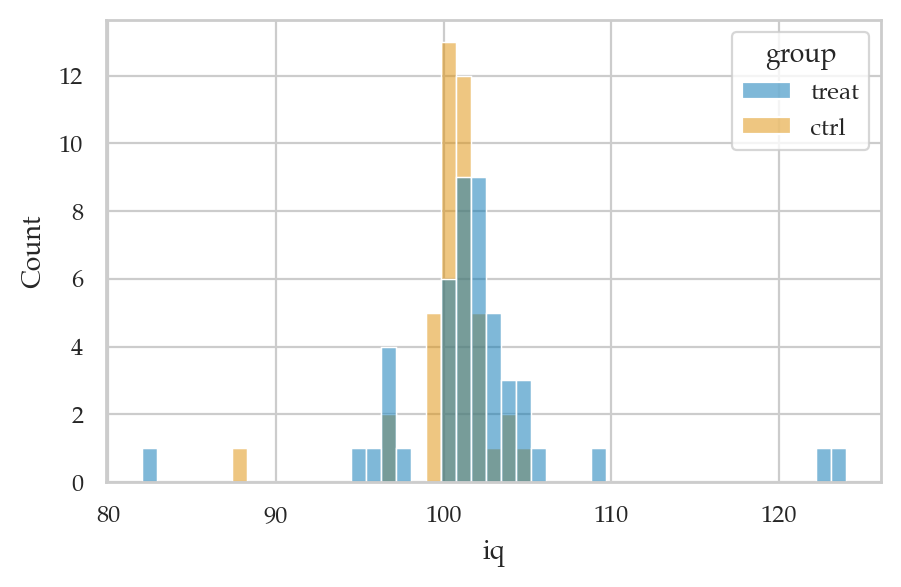

In [34]:
sns.histplot(data=iqs2, x="iq", hue="group");

### Bayesian model
TODO: add formulas

### Bambi model

In [35]:
formula3 = bmb.Formula("iq ~ 0 + group",
                       "sigma ~ 0 + group")

mod3 = bmb.Model(formula=formula3,
                 family="t",
                 link="identity",
                 # relying on default priors
                 data=iqs2)
mod3

       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: [0. 0.], sigma: [23.6275 23.6275])
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)

In [36]:
# # ALT use the function
# from ministats.bayes import bayes_dmeans
# treated = iqs2[iqs2["group"]=="treat"]["iq"].values
# controls = iqs2[iqs2["group"]=="ctrl"]["iq"].values
# mod3, idata3 = bayes_dmeans(treated, controls, var_name="iq",
#                             group_name="group", groups=["treat", "ctrl"])

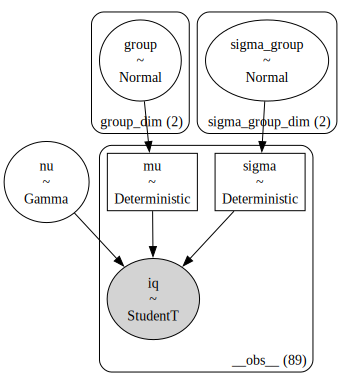

In [37]:
mod3.build()
mod3.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example3_iqs_mod3_graph")
# mod3.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [38]:
idata3 = mod3.fit(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


In [39]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata3, group_name="group");
az.summary(idata3, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_treat", "sigma_ctrl", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,1.015,0.424,0.179,1.853
sigma_treat,1.938,0.404,1.222,2.761
sigma_ctrl,1.010,0.198,0.643,1.409
dstd,0.928,0.412,0.142,1.750
nu,1.808,0.462,1.017,2.745
cohend,0.675,0.304,0.103,1.291


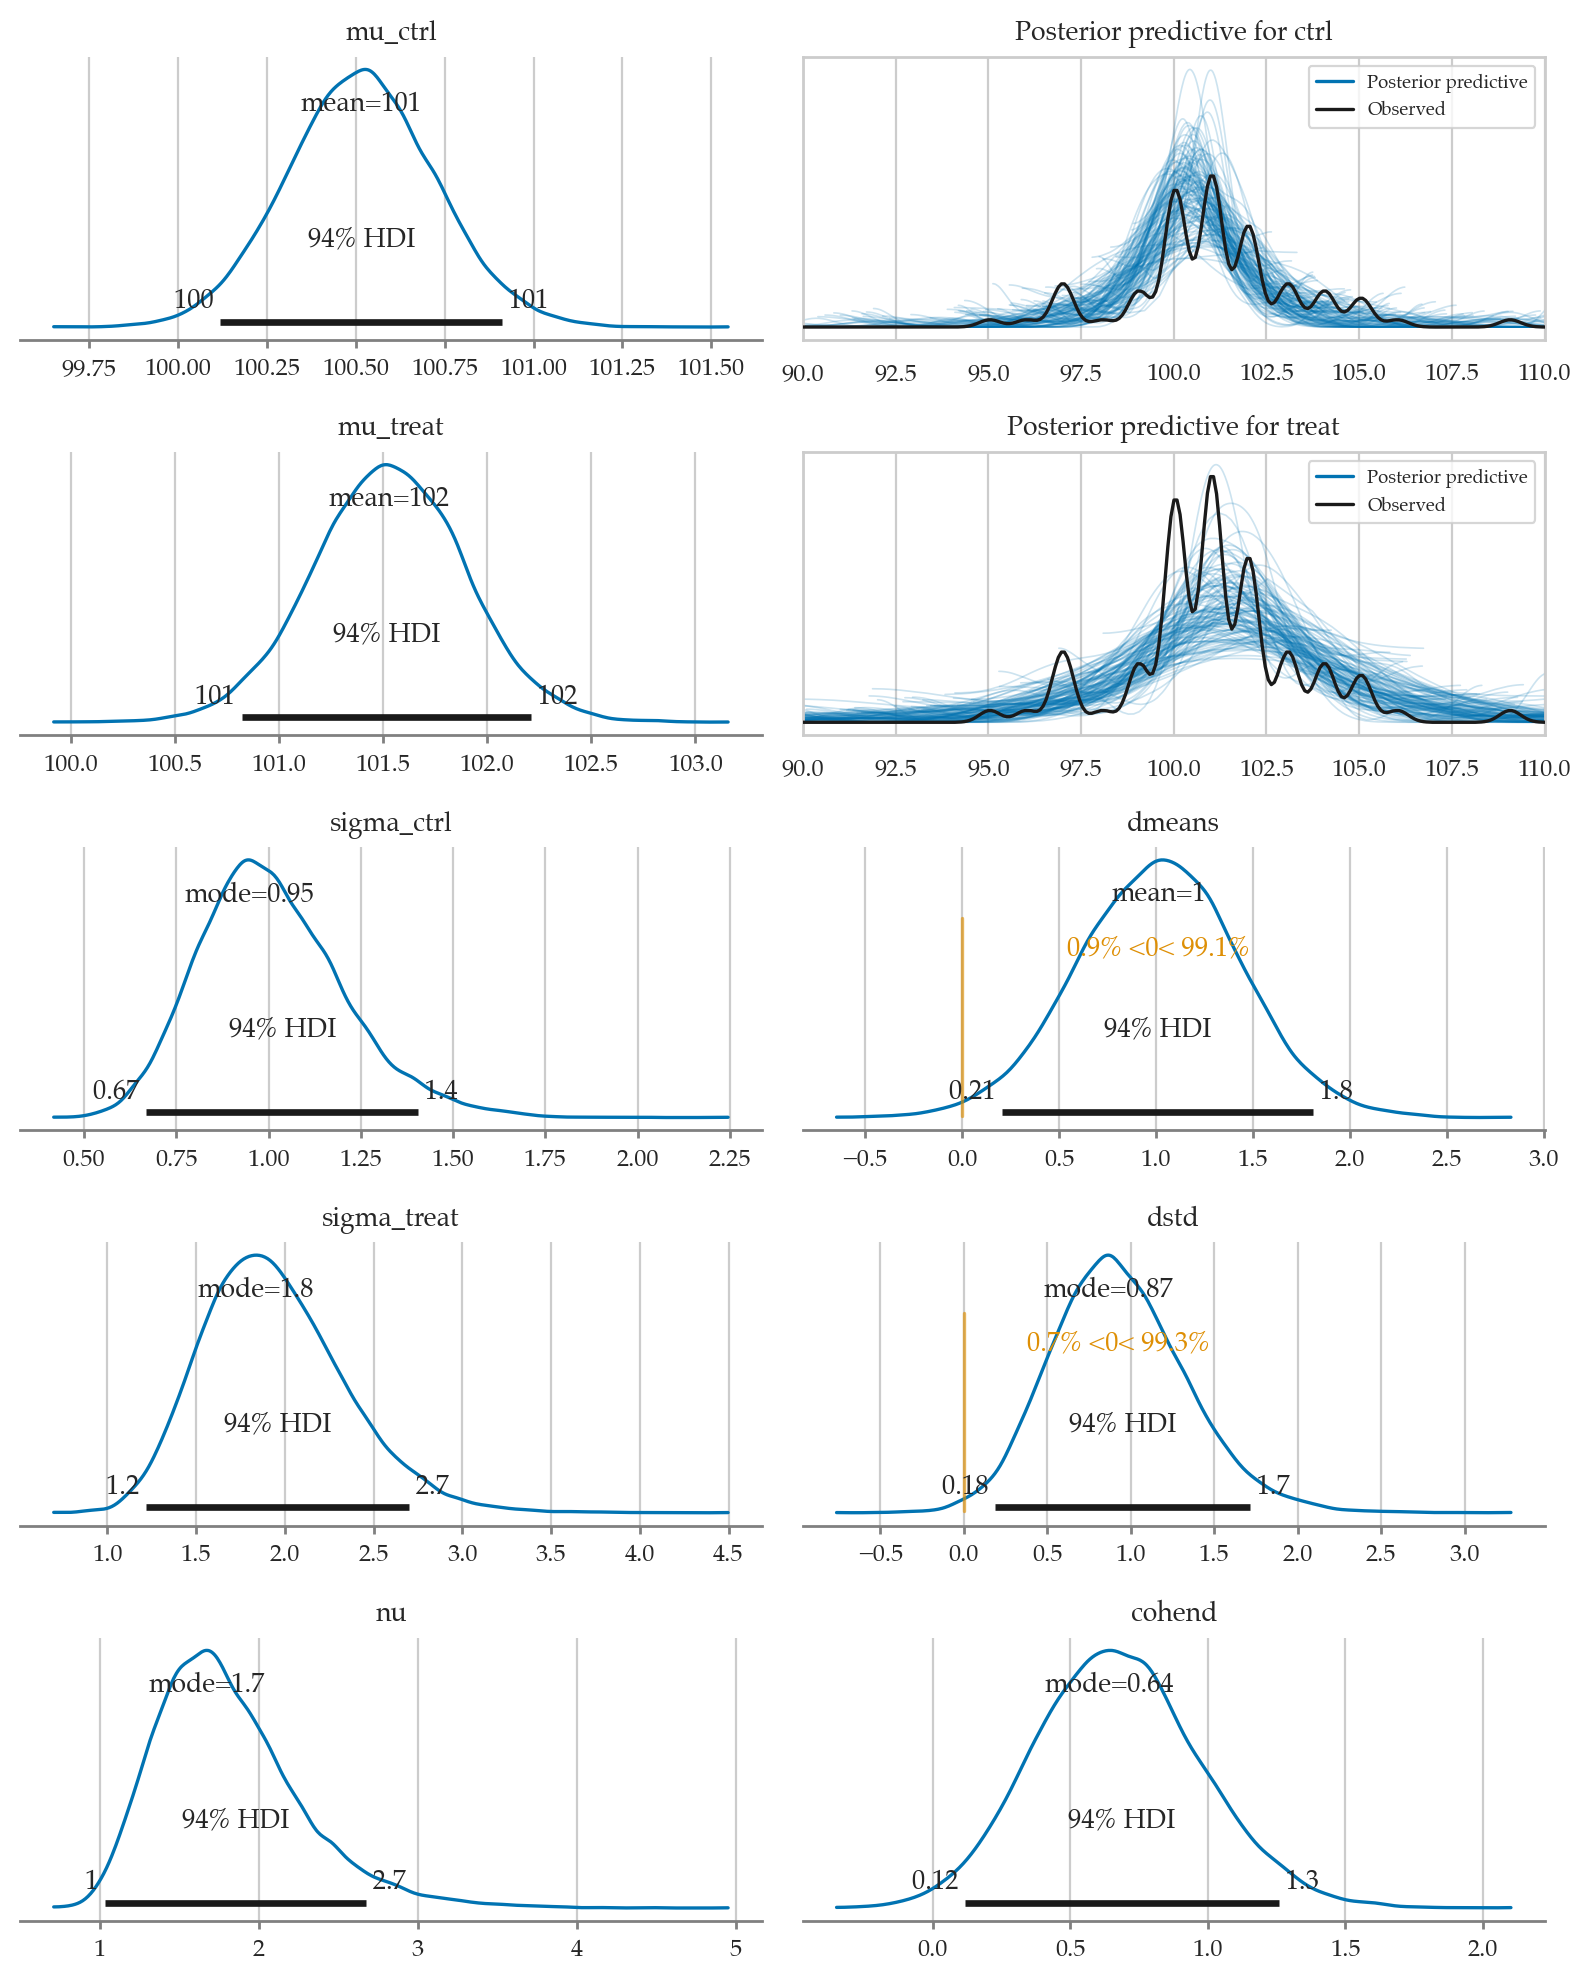

In [40]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod3, idata3, group_name="group", ppc_xlims=[90,110]);

In [41]:
# # FIGURES ONLY
# plot_dmeans_stats(mod3, idata3, group_name="group",
#                   ppc_xlims=[90,110], figsize=(6,6.5));
# filename = os.path.join(DESTDIR, "example3_dmeans_plots.pdf")
# savefigure(plt.gcf(), filename)

### Compare to previous results

In [42]:
from scipy.stats import ttest_ind
treated = iqs2[iqs2["group"]=="treat"]["iq"].values
controls = iqs2[iqs2["group"]=="ctrl"]["iq"].values

res3 = ttest_ind(treated, controls, equal_var=False)
res3.statistic, res3.pvalue, res3.df

(1.622190457290228, 0.10975381983712836, 63.03889717357651)

In [43]:
from ministats import cohend2
cohend2(treated, controls)

0.3309654530139732

### Conclusions

## Explanations


### Alternative choices of priors
e.g. prior for sigma as very wiiiiiide, and  nu ~ Exp(1/29)+1 → BEST
Bayesian estimation supersedes the t-test by John K. Kruschke
- https://jkkweb.sitehost.iu.edu/articles/Kruschke2013JEPG.pdf 
- https://www.sumsar.net/blog/2013/06/best-online/ 

If we use a model with common standard deviation, we get equivalent of pooled sigma


### Sensitivity analysis and robustness checks

## Performance tests

### Simulated datasets

Simulate data grid consisting of ∆ * outliers * n * m

### Model comparisons

Compare results several models:
- N model
- T model (robust)
- BayesFactor based on JZS prior
- Classical two-sample t-test (from Section 4.5)


## Discussion

### Comparison to the frequentist two-sample t-test

- results numerically similar
- note we're using 𝒯 as data model, not as a sampling distribution
- conceptually different:
  - p-value vs. decision based on posterior distribution
  - confidence intervals vs. credible intervals

### Comparing multiple groups

- ?Extension to Bayesian ANOVA? Can extend approach to multiple groups: Bayesian ANOVA

FWD reference to hierarchical models for group comparison covered in Section 5.5


## Exercises

### Exercise 1: small samples

In [44]:
As = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
Bs = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]
groups = ["A"]*len(As) + ["B"]*len(Bs)
df1 = pd.DataFrame({"group": groups, "vals": As + Bs})
# df1

In [45]:
from scipy.stats import t as tdist

tdist(loc=100, scale=10, df=2.1).std()

45.82575694955838

In [46]:
10 * np.sqrt(2.1 / (2.1-2))

45.82575694955838

alpha=1.0 beta=0.03333333333333333


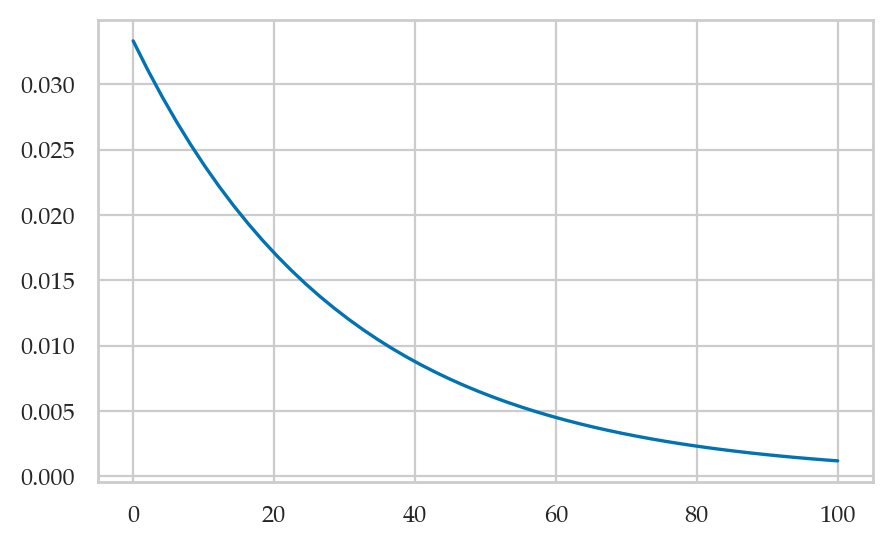

In [47]:
# New Default prior in R BEST code
from scipy.stats import gamma

nuMean = 30
nuSD = 30

alpha = nuMean**2 / nuSD**2  # shape
beta = nuMean / nuSD**2   # rate
print(f"{alpha=} {beta=}")

rv_Nu = gamma(a=alpha, scale=1/beta)
xs = np.linspace(0,100)
ax = sns.lineplot(x=xs, y=rv_Nu.pdf(xs));

<Axes: >

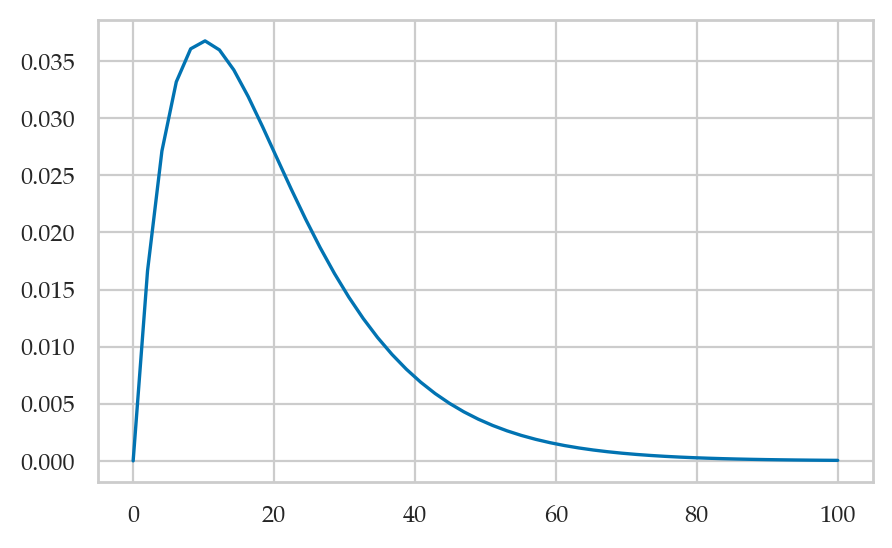

In [48]:
# Bambi default prior for `nu`
rv_Nu2 = gamma(a=2, scale=10)
xs = np.linspace(0,100)
sns.lineplot(x=xs, y=rv_Nu2.pdf(xs))

### Exercise 2: redo exercises from Section 3.5 section using Bayesian methods

### Exercise 3: comparing IQ scores


smart drug administered to `treatment` group and want to compare to `control` group. Data contains outliers)

cf. [compare_iqs2_many_ways.ipynb](./explorations/compare_iqs2_many_ways.ipynb)

## Links

# BONUS Examples

## Example 4: small example form BEST vignette

See http://cran.nexr.com/web/packages/BEST/vignettes/BEST.pdf#page=2


In [49]:
y1s = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
y2s = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]

from ministats.bayes import bayes_dmeans
mod4, idata4 = bayes_dmeans(y1s, y2s, groups=["y1", "y2"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [50]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata4)
az.summary(idata4, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_y1", "sigma_y2", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-1.450,0.516,-2.518,-0.446
sigma_y1,0.859,0.331,0.376,1.501
sigma_y2,0.727,0.293,0.296,1.298
dstd,-0.132,0.444,-1.107,0.684
nu,21.756,14.278,1.611,50.229
cohend,-1.910,0.798,-3.459,-0.350


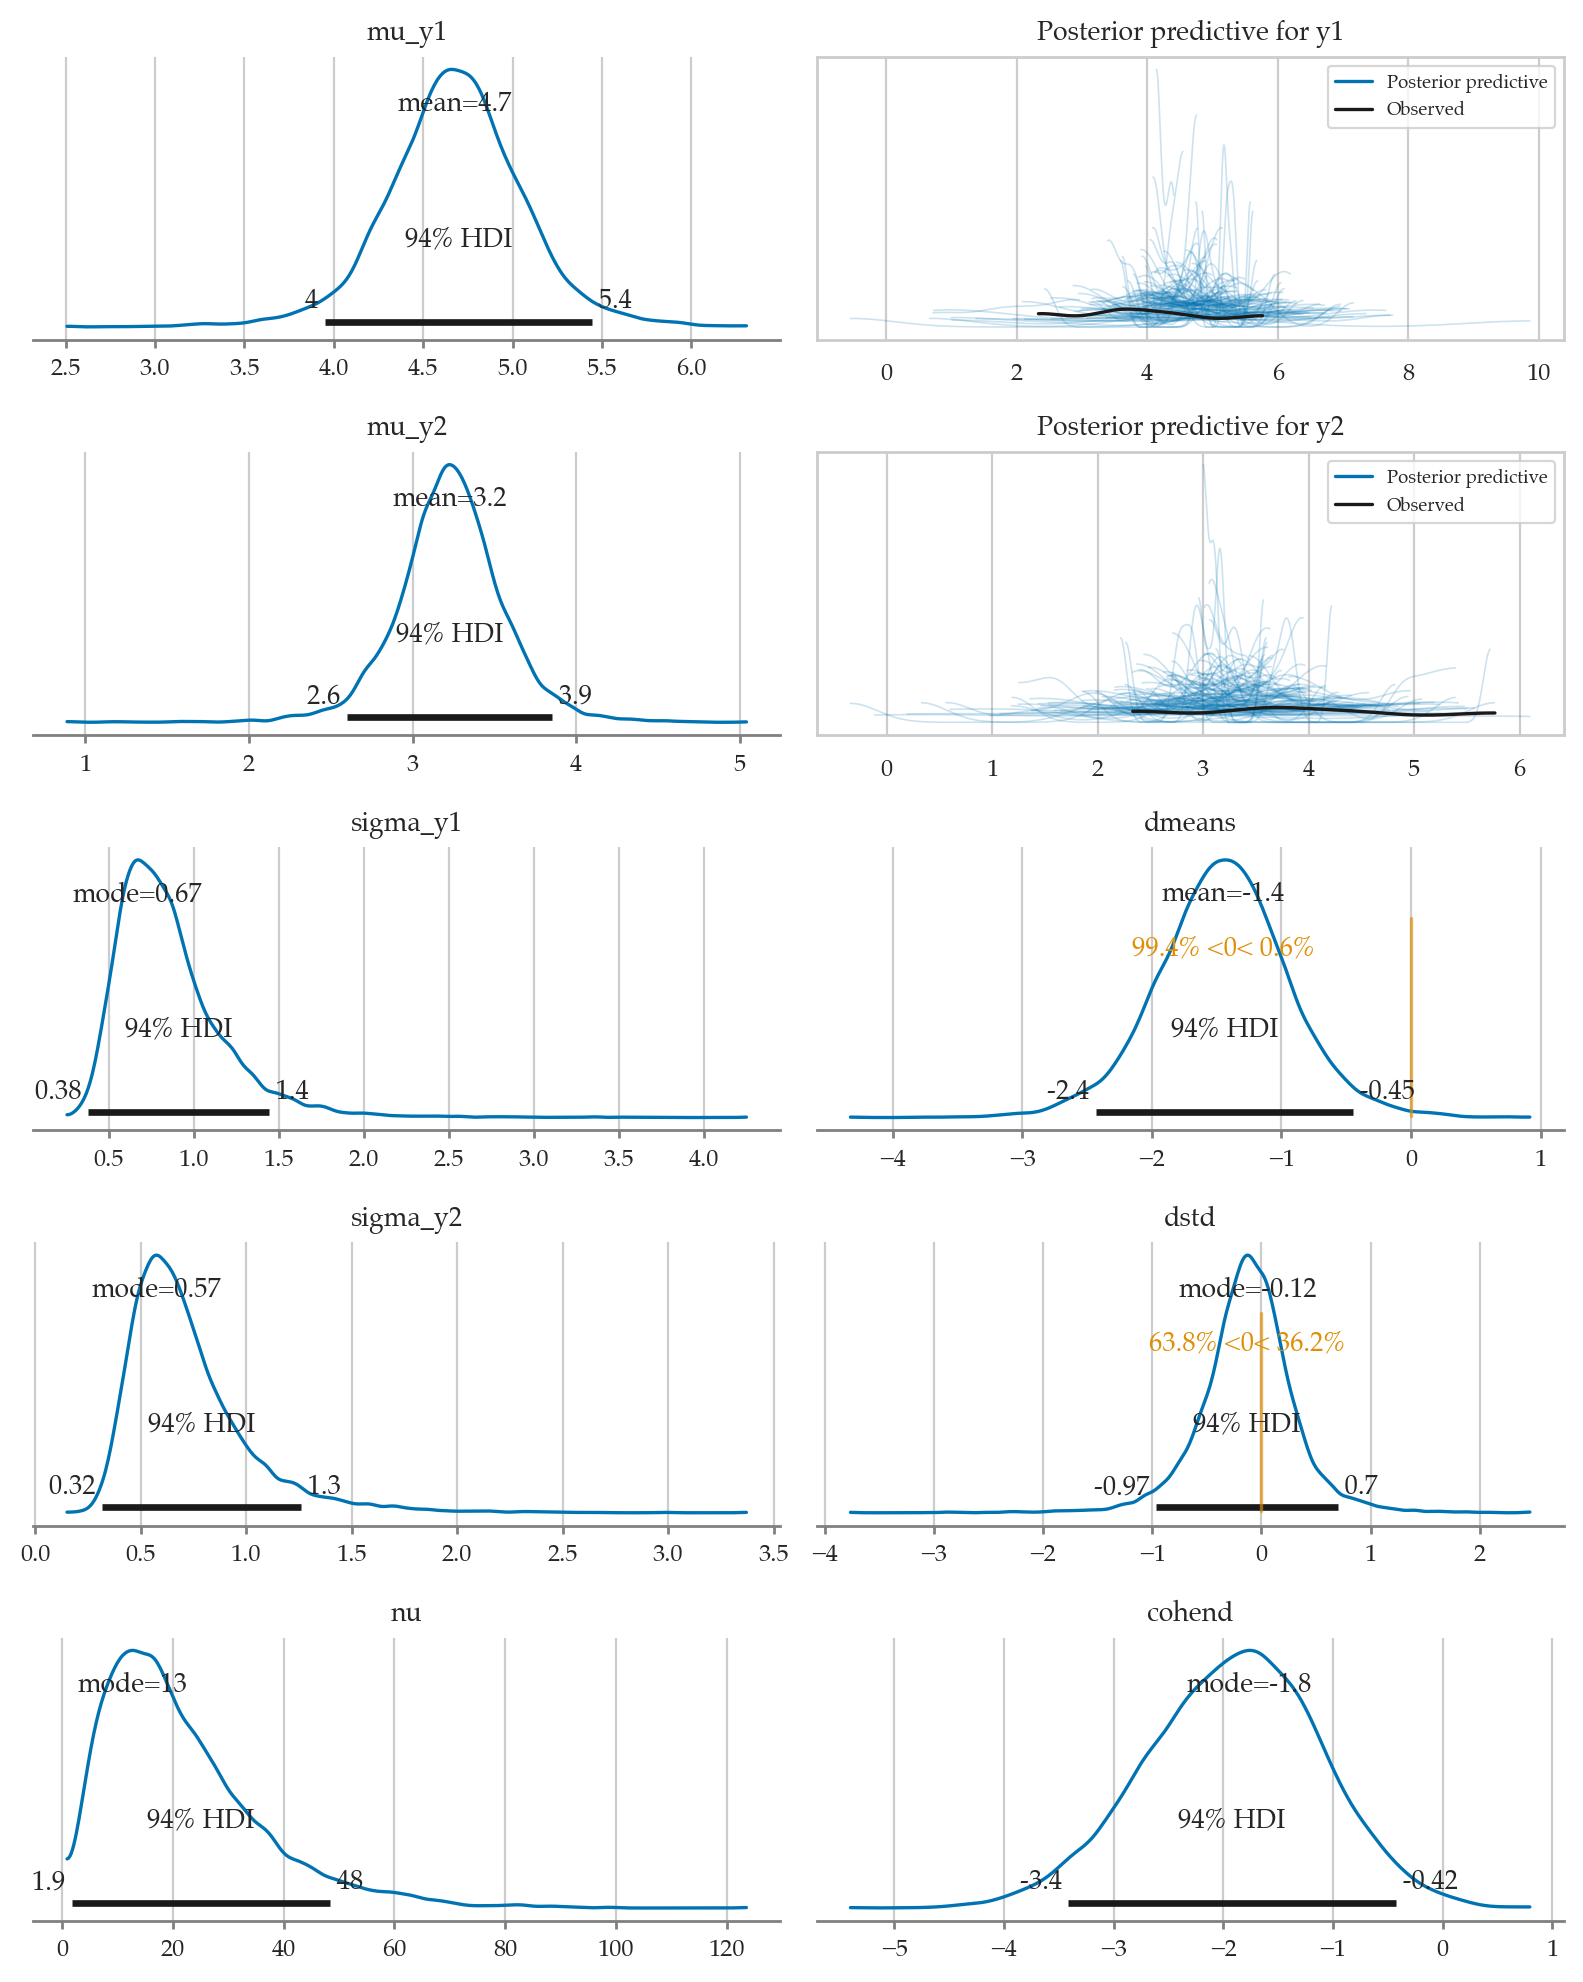

In [51]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod4, idata4, ppc_xlims=None);

## Example 5: comparing morning to evening

https://github.com/treszkai/best/blob/master/examples/paired_samples.py


In [52]:
morning = [8.99, 9.21, 9.03, 9.15, 8.68, 8.82, 8.66, 8.82, 8.59, 8.14,
           9.09, 8.80, 8.18, 9.23, 8.55, 9.03, 9.36, 9.06, 9.57, 8.38]
evening = [9.82, 9.34, 9.73, 9.93, 9.33, 9.41, 9.48, 9.14, 8.62, 8.60,
           9.60, 9.41, 8.43, 9.77, 8.96, 9.81, 9.75, 9.50, 9.90, 9.13]

In [53]:
from ministats.bayes import bayes_dmeans
mod5, idata5 = bayes_dmeans(evening, morning, groups=["evening", "morning"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [54]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata5)
az.summary(idata5, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_evening", "sigma_morning", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-0.526,0.142,-0.797,-0.236
sigma_evening,0.455,0.087,0.301,0.624
sigma_morning,0.388,0.073,0.258,0.533
dstd,-0.068,0.111,-0.285,0.153
nu,23.119,14.213,2.357,50.223
cohend,-1.260,0.379,-2.020,-0.535


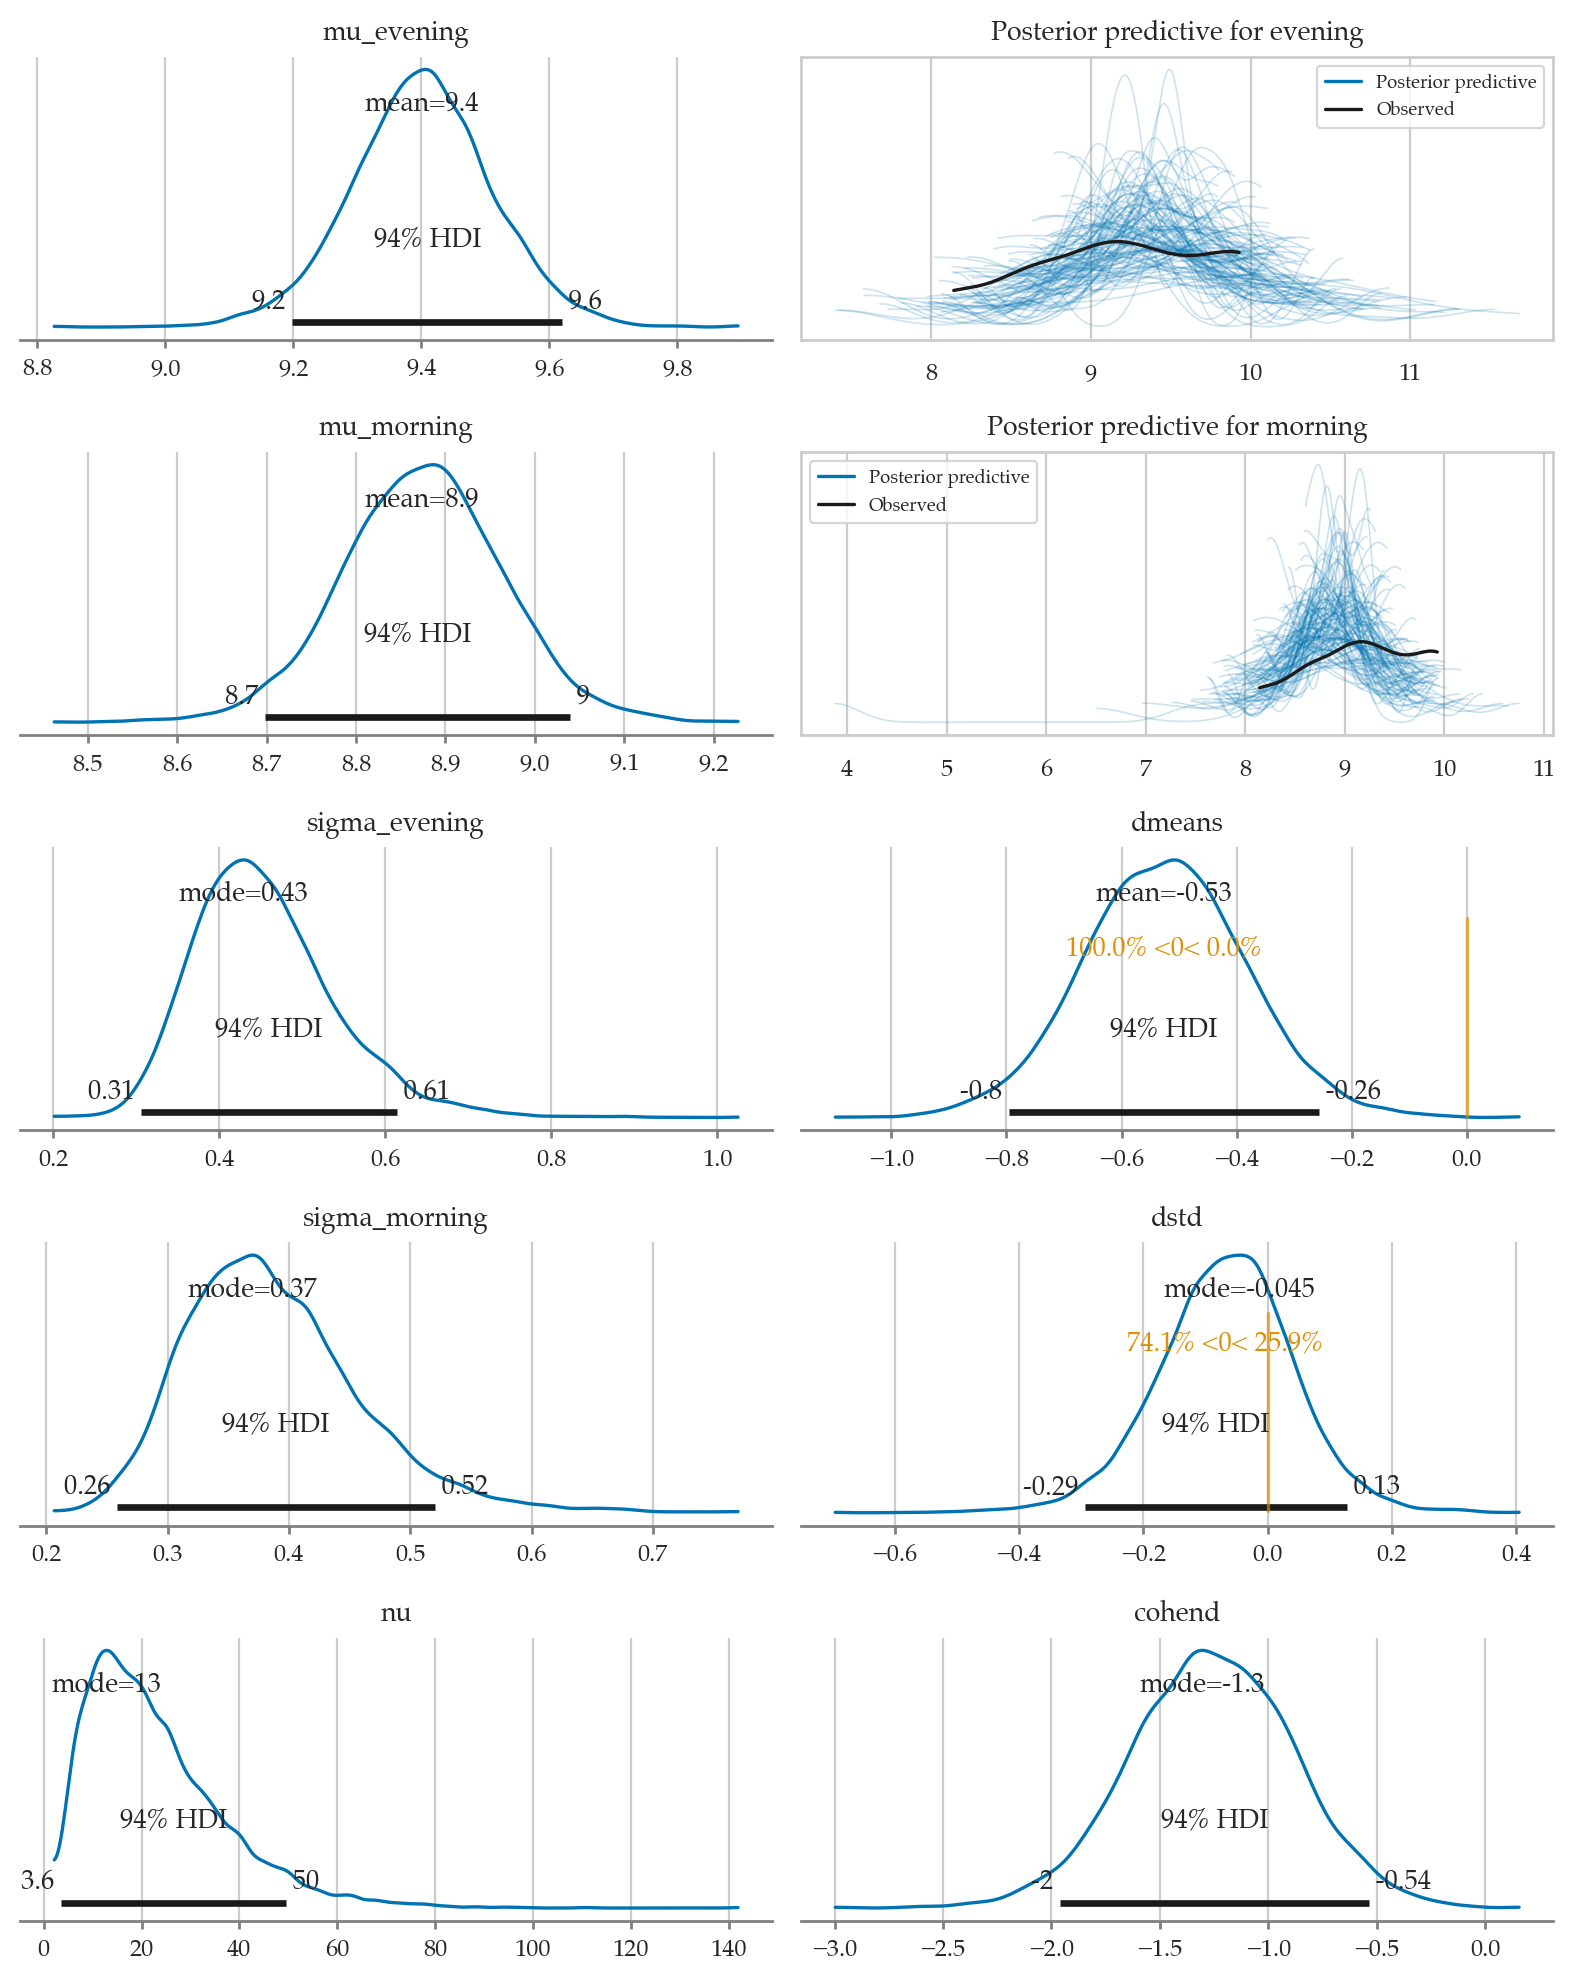

In [55]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod5, idata5, ppc_xlims=None);